Hans Ardianta  
2702249663

Link Video Penjelasan:  
https://drive.google.com/file/d/15YCGWUgb-UhLw3NUtIAFNBZv5fgmtmwl/view?usp=sharing

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import glob

import os

# untuk image reading
from PIL import Image
import cv2

import tensorflow as tf

SEED_VALUE = 54
np.random.seed(SEED_VALUE)
import random
random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [2]:
path_imgdata = "B_23"

image_size = (100,100)
batch_size = 32



## a. EDA

### Ukuran dataset

In [3]:
image_files = [f for f in os.listdir(path_imgdata) if f.lower().endswith(('.jpg', '.jpeg', '.png'))] 
jumlah = len(image_files)

print(f"Terdapat {jumlah} gambar di dalam dataset.")

Terdapat 1074 gambar di dalam dataset.


### Mengecek sample image

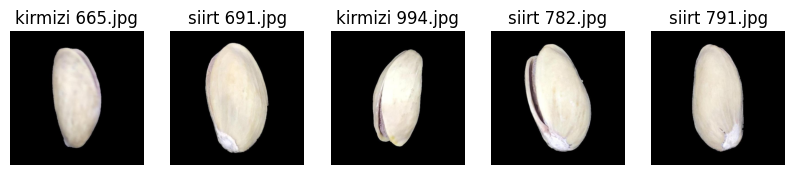

In [4]:
img_paths = os.listdir(os.path.join(path_imgdata))
sample_imgs = random.sample(img_paths, min(5, len(img_paths)))

plt.figure(figsize=(10,2))
for i, img_name in enumerate(sample_imgs):
    img_path = os.path.join(path_imgdata,img_name)
    img = cv2.imread(img_path)[..., ::-1]  # BGR to RGB
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(img_name)
plt.show()

Dataset ini berisi gambar kacang-kacang yaitu jenis kirmizi dan siirt. Kedua kacang ini adalah dua jenis kacang pistachio.

### Mengecek ukuran gambar

In [5]:
total_images = 0
not_100x100 = 0

sizes = []

# Loop semua file di folder
for filename in os.listdir(path_imgdata):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
        total_images += 1
        img_path = os.path.join(path_imgdata, filename)
        img = Image.open(img_path) 
        width, height = img.size
        sizes.append((width, height))
        if (width, height) != (100, 100):
            not_100x100 += 1

# Hasil
print(f"Total gambar: {total_images}")
print(f"Gambar yang TIDAK berukuran 100x100: {not_100x100}")
print(f"Gambar yang berukuran 100x100: {total_images - not_100x100}")


Total gambar: 1074
Gambar yang TIDAK berukuran 100x100: 1074
Gambar yang berukuran 100x100: 0


Seluruh gambar belum berada dalam ukuran resolusi yang diterima model yaitu 100x100

### Melihat tipe data dataset gambar

In [6]:
image_extensions = set()

# Loop semua file dan ambil ekstensinya
for filename in os.listdir(path_imgdata):
    ext = os.path.splitext(filename)[1].lower()  # ambil ekstensi dan lowercase
    if ext:  # hanya kalau ada ekstensi
        image_extensions.add(ext)

print("Tipe-tipe data gambar yang ditemukan:")
for ext in sorted(image_extensions):
    print(ext)


Tipe-tipe data gambar yang ditemukan:
.jpg


Hanya ada tipe gambar JPG pada dataset ini

### Mengecek tipe data dan resolusi piksel gambar
Untuk melakukan Gaussian noising, kita memerlukan piksel-piksel dalam floating point

In [7]:
image_paths = glob.glob(os.path.join(path_imgdata, '*'))

# Load beberapa gambar untuk analisis
num_samples = 9
images = []

for i, path in enumerate(image_paths[:num_samples]):
    img = Image.open(path).convert('L')  # convert to grayscale (optional)
    img_array = np.array(img)
    images.append(img_array)

    # Tampilkan dtype
    print(f'Gambar ke-{i+1}: {os.path.basename(path)} - dtype: {img_array.dtype}, shape: {img_array.shape}')


Gambar ke-1: kirmizi 1000.jpg - dtype: uint8, shape: (600, 600)
Gambar ke-2: kirmizi 1001.jpg - dtype: uint8, shape: (600, 600)
Gambar ke-3: kirmizi 1002.jpg - dtype: uint8, shape: (600, 600)
Gambar ke-4: kirmizi 1003.jpg - dtype: uint8, shape: (600, 600)
Gambar ke-5: kirmizi 1004.jpg - dtype: uint8, shape: (600, 600)
Gambar ke-6: kirmizi 1005.jpg - dtype: uint8, shape: (600, 600)
Gambar ke-7: kirmizi 1006.jpg - dtype: uint8, shape: (600, 600)
Gambar ke-8: kirmizi 1007.jpg - dtype: uint8, shape: (600, 600)
Gambar ke-9: kirmizi 1008.jpg - dtype: uint8, shape: (600, 600)


Bisa dilihat tipe data nya masih uint8 maka nanti akan kita ganti menjadi float.  
Ukuran resolusi gambar juga kebanyakan 600x600, maka nanti akan kita resize menjadi 100x100.

### Melihat Histogram Piksel dan Rata-rata piksel pada gambar

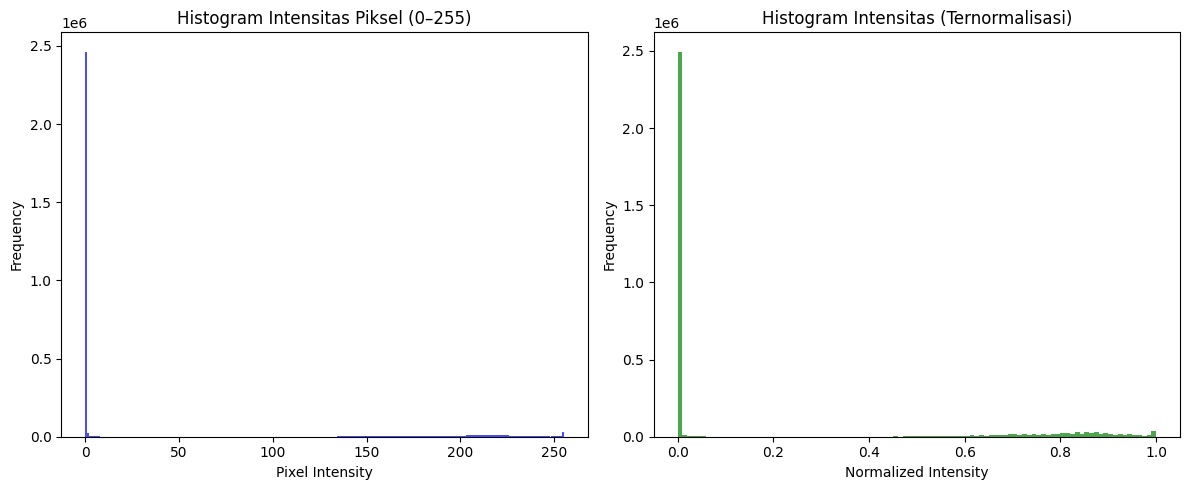

In [8]:
# === Plot histogram intensitas piksel ===
all_pixels = np.concatenate([img.flatten() for img in images])

# Jika ingin normalisasi, ubah piksel ke float32 terlebih dahulu
all_pixels_normalized = all_pixels.astype(np.float32) / 255.0

plt.figure(figsize=(12, 5))

# Histogram original
plt.subplot(1, 2, 1)
plt.hist(all_pixels, bins=256, range=(0, 255), color='blue', alpha=0.7)
plt.title('Histogram Intensitas Piksel (0–255)')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

# Histogram setelah normalisasi
plt.subplot(1, 2, 2)
plt.hist(all_pixels_normalized, bins=100, range=(0.0, 1.0), color='green', alpha=0.7)
plt.title('Histogram Intensitas (Ternormalisasi)')
plt.xlabel('Normalized Intensity')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [9]:
for i, img in enumerate(images):
    print(f"Image {i+1} - Mean pixel intensity: {np.mean(img)}")

Image 1 - Mean pixel intensity: 45.180883333333334
Image 2 - Mean pixel intensity: 49.89678055555556
Image 3 - Mean pixel intensity: 34.12779722222222
Image 4 - Mean pixel intensity: 40.675044444444445
Image 5 - Mean pixel intensity: 53.1847
Image 6 - Mean pixel intensity: 53.16256111111111
Image 7 - Mean pixel intensity: 48.96358333333333
Image 8 - Mean pixel intensity: 36.04499166666667
Image 9 - Mean pixel intensity: 42.404497222222226


## b. Split Dataset dan Menambahkan Noise

In [10]:
from sklearn.model_selection import train_test_split

# Split paths
train, temp = train_test_split(image_paths, test_size=0.2, random_state=42)
val, test = train_test_split(temp, test_size=0.5, random_state=42)

# Preprocessing
def load_and_preprocess_rgb(paths):
    data = []
    for path in paths:
        img = Image.open(path).convert('RGB').resize((100, 100))
        img = np.array(img).astype(np.float32) / 255.0  # Normalisasi
        noisy = img + np.random.normal(0.0, 0.1, img.shape)
        noisy = np.clip(noisy, 0., 1.)
        data.append((noisy,img))
    return data

# Load data
train_data = load_and_preprocess_rgb(train)
val_data = load_and_preprocess_rgb(val)
test_data = load_and_preprocess_rgb(test)

# Pisah input-target
X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)
X_test, y_test = zip(*test_data)

# Ubah ke numpy array (tanpa newaxis!)
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)


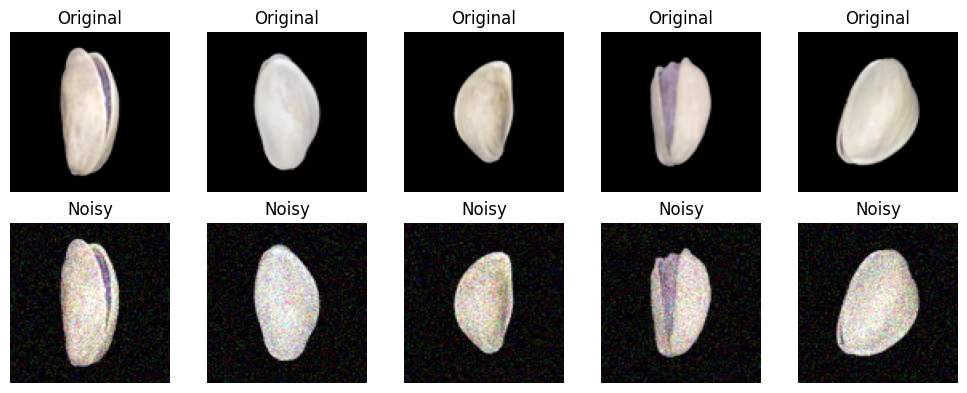

In [11]:
def show_original_vs_noisy(X, y, n=5):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(y[i])
        plt.title("Original")
        plt.axis('off')
        
        # Gambar noisy (input)
        plt.subplot(2, n, i + 1 + n)
        plt.imshow(X[i])
        plt.title("Noisy")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Tampilkan 5 gambar pertama
show_original_vs_noisy(X_train, y_train, n=5)


In [12]:
print(X_train.shape,X_val.shape,X_test.shape)
print(y_train.shape,y_val.shape,y_test.shape)

(859, 100, 100, 3) (107, 100, 100, 3) (108, 100, 100, 3)
(859, 100, 100, 3) (107, 100, 100, 3) (108, 100, 100, 3)


## c. Baseline Model

In [13]:
from tensorflow.keras import layers, models

def build_baseline_autoencoder():
    input_img = layers.Input(shape=(100, 100, 3))

    # Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  

    # Decoder
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    model = models.Model(input_img, decoded)
    model.compile(optimizer='adam', loss='mse')
    return model

baseline_model = build_baseline_autoencoder()
baseline_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Buat callback
early_stop = EarlyStopping(
    monitor='val_loss',     
    patience=5,             
    restore_best_weights=True,
    verbose =1
)

baseline_history = baseline_model.fit(
    X_train, y_train,
    epochs=70,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - loss: 0.1334 - val_loss: 0.0108
Epoch 2/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0107 - val_loss: 0.0106
Epoch 3/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 0.0075 - val_loss: 0.0037
Epoch 4/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0035 - val_loss: 0.0026
Epoch 5/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 6/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 7/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 8/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 9/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 10/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 107ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 11/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 12/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step 

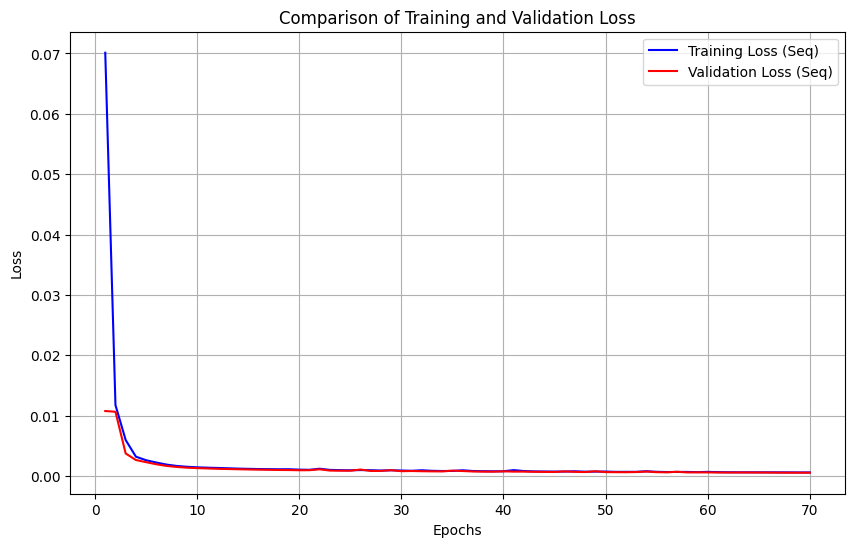

In [15]:

# Ambil data loss dan val_loss dari history masing-masing pelatihan
loss_seq2 = baseline_history.history['loss']
val_loss_seq2 = baseline_history.history['val_loss']


epochs_seq2 = range(1, len(loss_seq2) + 1)

# Plot grafik perbandingan
plt.figure(figsize=(10, 6))

# Plot training loss dan val_loss untuk model Sequential
plt.plot(epochs_seq2, loss_seq2, label='Training Loss (Seq)', color='b')
plt.plot(epochs_seq2, val_loss_seq2, label='Validation Loss (Seq)', color='r')

# Menambahkan label dan title
plt.title('Comparison of Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## d. Modified Model

In [16]:
from tensorflow.keras import layers, models

def build_modified_autoencoder():
    input_img = layers.Input(shape=(100, 100, 3))

    # ENCODER
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.BatchNormalization()(x)  # NEW
    x = layers.MaxPooling2D((2, 2), padding='same')(x)  # 100 → 50

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.Dropout(0.2)(x)  # NEW
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)  # 50 → 25

    # DECODER
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)  # 25 → 50

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)  # NEW
    x = layers.UpSampling2D((2, 2))(x)  # 50 → 100

    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # 100×100×3

    model = models.Model(input_img, decoded)
    model.compile(optimizer='adam', loss='mse')
    return model

modified_model = build_modified_autoencoder()
modified_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50, 50, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,907 (296.51 KB)

 Trainable params: 75,779 (296.01 KB)

 Non-trainable params: 128 (512.00 B)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

# Buat callback
early_stop = EarlyStopping(
    monitor='val_loss',     
    patience=5,             
    restore_best_weights=True,
    verbose =1
)

modif_history = modified_model.fit(
    X_train, y_train,
    epochs=70,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - loss: 0.0686 - val_loss: 0.1612
Epoch 2/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 166ms/step - loss: 0.0123 - val_loss: 0.1364
Epoch 3/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - loss: 0.0106 - val_loss: 0.1273
Epoch 4/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - loss: 0.0084 - val_loss: 0.1074
Epoch 5/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - loss: 0.0063 - val_loss: 0.0860
Epoch 6/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - loss: 0.0050 - val_loss: 0.0608
Epoch 7/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - loss: 0.0041 - val_loss: 0.0448
Epoch 8/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - loss: 0.0036 - val_loss: 0.0309
Epoch 9/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - loss: 0.0032 - val_loss: 0.0266
Epoch 10/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 162ms/step - loss: 0.0027 - val_loss: 0.0211
Epoch 11/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 167ms/step - loss: 0.0024 - val_loss: 0.0179
Epoch 12/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step

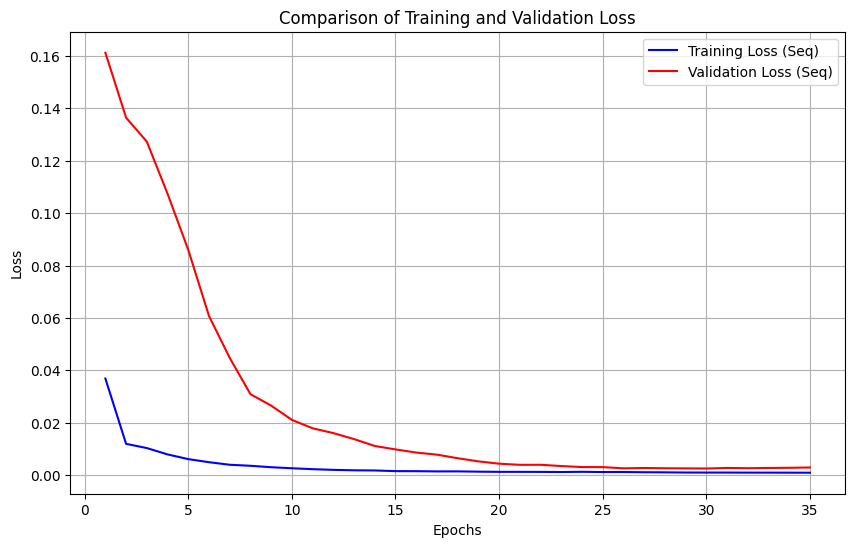

In [18]:

# Ambil data loss dan val_loss dari history masing-masing pelatihan
loss_seq2 = modif_history.history['loss']
val_loss_seq2 = modif_history.history['val_loss']


epochs_seq2 = range(1, len(loss_seq2) + 1)

# Plot grafik perbandingan
plt.figure(figsize=(10, 6))

# Plot training loss dan val_loss untuk model Sequential
plt.plot(epochs_seq2, loss_seq2, label='Training Loss (Seq)', color='b')
plt.plot(epochs_seq2, val_loss_seq2, label='Validation Loss (Seq)', color='r')

# Menambahkan label dan title
plt.title('Comparison of Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## e. Evaluasi

In [19]:
base_pred = baseline_model.predict(X_test)

modif_pred = modified_model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


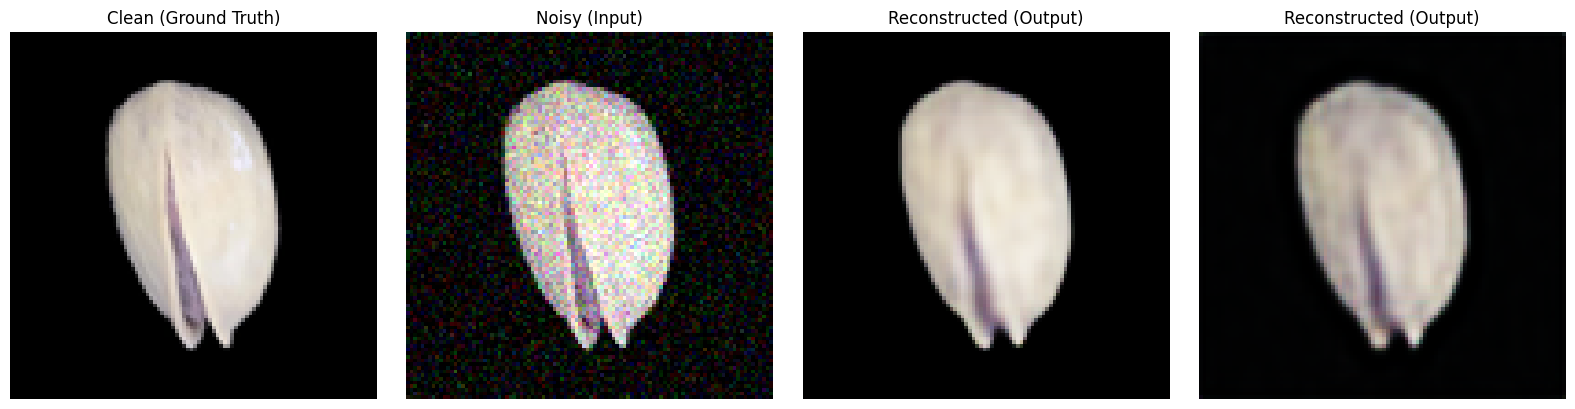

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Ambil indeks data yang ingin ditampilkan
idx = 0

# Ambil data untuk ditampilkan
noisy_img = X_test[idx]
clean_img = y_test[idx]
predicted_img = base_pred[idx]
predicted_img2 = modif_pred[idx]

# Jika perlu konversi ke uint8 (biar bisa ditampilkan lebih jelas)
def to_uint8(img):
    return (img * 255).astype(np.uint8)

# Tampilkan hasil
plt.figure(figsize=(16, 4))

plt.subplot(1, 4, 1)
plt.imshow(to_uint8(clean_img))
plt.title("Clean (Ground Truth)")
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(to_uint8(noisy_img))
plt.title("Noisy (Input)")
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(to_uint8(predicted_img))
plt.title("Reconstructed (Output)")
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(to_uint8(predicted_img2))
plt.title("Reconstructed (Output)")
plt.axis('off')

plt.tight_layout()
plt.show()


### Nilai SSIM untuk kedua model

In [ ]:
from skimage.metrics import structural_similarity as ssim
import numpy as np


def compute_ssim_scores(originals, reconstructions):
    scores = []
    for i in range(len(originals)):
        s = ssim(
            originals[i], 
            reconstructions[i], 
            channel_axis=2,         
            data_range=1.0
        )
        scores.append(s)
    return np.mean(scores)

ssim_base = compute_ssim_scores(y_test, base_pred)
ssim_mod = compute_ssim_scores(y_test, modif_pred)

print(f"SSIM Model Baseline   : {ssim_base:.4f}")
print(f"SSIM Model Modifikasi : {ssim_mod:.4f}")


SSIM Model Baseline   : 0.9564
SSIM Model Modifikasi : 0.6078


SSIM mengukur kualitas suatu gambar, mengecek kesamaan struktur indeks pada gambar. Baseline model mendapat nilai yang lebih tinggi, dengan mampu memiliki 95% kesamaan struktur dengan image aslinya.